<a href="https://colab.research.google.com/github/klu2300030025/GAN_SSKILL_PROJECT-1/blob/main/GAN_for_images_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# Load MNIST automatically
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [-1, 1]
x_train = x_train.astype("float32")
x_train = (x_train / 127.5) - 1.0

# Add channel dimension → (28,28,1)
x_train = np.expand_dims(x_train, axis=-1)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Dataset ready:", x_train.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset ready: (60000, 28, 28, 1)


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Dense(1024),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Dense(28 * 28 * 1, activation='tanh'),
        tf.keras.layers.Reshape((28, 28, 1))
    ])
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)


In [ ]:
@tf.function
def train_discriminator(real_images):
    batch_size = tf.shape(real_images)[0]

    # Add noise to real images (noise injection)
    real_images = real_images + 0.05 * tf.random.normal(tf.shape(real_images))

    noise = tf.random.normal([batch_size, 100])
    fake_images = generator(noise, training=True)

    # Label smoothing
    real_labels = tf.ones((batch_size, 1)) * 0.9
    fake_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as d_tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        d_loss_real = cross_entropy(real_labels, real_output)
        d_loss_fake = cross_entropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake

    gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(
        zip(gradients, discriminator.trainable_variables)
    )

    return d_loss


@tf.function
def train_generator(batch_size):
    noise = tf.random.normal([batch_size, 100])
    real_labels = tf.ones((batch_size, 1)) * 0.9

    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = cross_entropy(real_labels, fake_output)

    gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(
        zip(gradients, generator.trainable_variables)
    )

    return g_loss


In [ ]:
def generate_and_save_images(model, epoch):
    noise = tf.random.normal([16, 100])
    images = model(noise, training=False)

    images = (images + 1.0) / 2.0  # back to [0,1]

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.show()


Epoch 1/80 | D Loss: 0.9735 | G Loss: 1.2108
Epoch 2/80 | D Loss: 0.9827 | G Loss: 1.1477
Epoch 3/80 | D Loss: 1.0122 | G Loss: 1.2350
Epoch 4/80 | D Loss: 1.0441 | G Loss: 1.3502
Epoch 5/80 | D Loss: 1.0502 | G Loss: 1.4026
Epoch 6/80 | D Loss: 1.0565 | G Loss: 1.3898
Epoch 7/80 | D Loss: 1.0743 | G Loss: 1.3816
Epoch 8/80 | D Loss: 1.0767 | G Loss: 1.3636
Epoch 9/80 | D Loss: 1.0860 | G Loss: 1.3482
Epoch 10/80 | D Loss: 1.0892 | G Loss: 1.3443


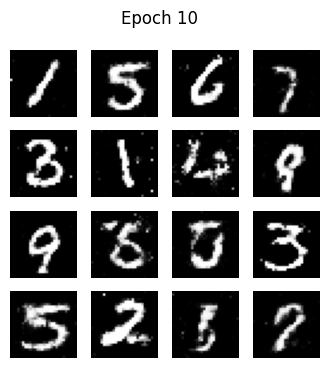

Epoch 11/80 | D Loss: 1.0885 | G Loss: 1.3537
Epoch 12/80 | D Loss: 1.0963 | G Loss: 1.3488
Epoch 13/80 | D Loss: 1.0933 | G Loss: 1.3383
Epoch 14/80 | D Loss: 1.0991 | G Loss: 1.3415
Epoch 15/80 | D Loss: 1.0975 | G Loss: 1.3380
Epoch 16/80 | D Loss: 1.1014 | G Loss: 1.3442
Epoch 17/80 | D Loss: 1.1034 | G Loss: 1.3369
Epoch 18/80 | D Loss: 1.1054 | G Loss: 1.3345
Epoch 19/80 | D Loss: 1.1075 | G Loss: 1.3234
Epoch 20/80 | D Loss: 1.1083 | G Loss: 1.3213


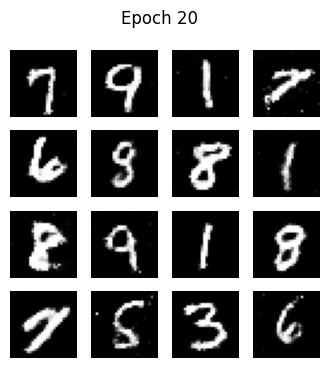

Epoch 21/80 | D Loss: 1.1110 | G Loss: 1.3274
Epoch 22/80 | D Loss: 1.1114 | G Loss: 1.3173
Epoch 23/80 | D Loss: 1.1090 | G Loss: 1.3175
Epoch 24/80 | D Loss: 1.1113 | G Loss: 1.3132
Epoch 25/80 | D Loss: 1.1103 | G Loss: 1.3140
Epoch 26/80 | D Loss: 1.1105 | G Loss: 1.3167
Epoch 27/80 | D Loss: 1.1119 | G Loss: 1.3098
Epoch 28/80 | D Loss: 1.1131 | G Loss: 1.3054
Epoch 29/80 | D Loss: 1.1106 | G Loss: 1.3079
Epoch 30/80 | D Loss: 1.1110 | G Loss: 1.3099


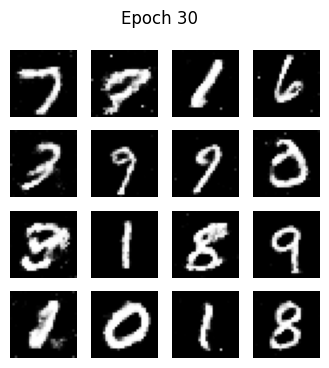

Epoch 31/80 | D Loss: 1.1145 | G Loss: 1.3028
Epoch 32/80 | D Loss: 1.1134 | G Loss: 1.3020
Epoch 33/80 | D Loss: 1.1137 | G Loss: 1.2918
Epoch 34/80 | D Loss: 1.1123 | G Loss: 1.2985
Epoch 35/80 | D Loss: 1.1146 | G Loss: 1.2973
Epoch 36/80 | D Loss: 1.1163 | G Loss: 1.2937
Epoch 37/80 | D Loss: 1.1150 | G Loss: 1.2842
Epoch 38/80 | D Loss: 1.1167 | G Loss: 1.2944
Epoch 39/80 | D Loss: 1.1179 | G Loss: 1.2776
Epoch 40/80 | D Loss: 1.1177 | G Loss: 1.2866


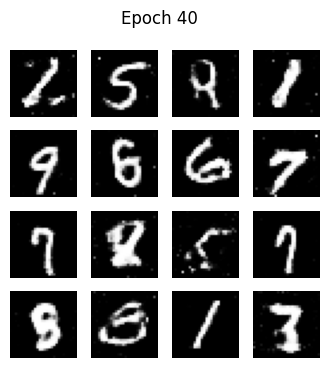

Epoch 41/80 | D Loss: 1.1225 | G Loss: 1.2737
Epoch 42/80 | D Loss: 1.1184 | G Loss: 1.2763
Epoch 43/80 | D Loss: 1.1238 | G Loss: 1.2715
Epoch 44/80 | D Loss: 1.1161 | G Loss: 1.2660
Epoch 45/80 | D Loss: 1.1207 | G Loss: 1.2688
Epoch 46/80 | D Loss: 1.1223 | G Loss: 1.2595
Epoch 47/80 | D Loss: 1.1202 | G Loss: 1.2688
Epoch 48/80 | D Loss: 1.1200 | G Loss: 1.2669
Epoch 49/80 | D Loss: 1.1221 | G Loss: 1.2578
Epoch 50/80 | D Loss: 1.1183 | G Loss: 1.2611


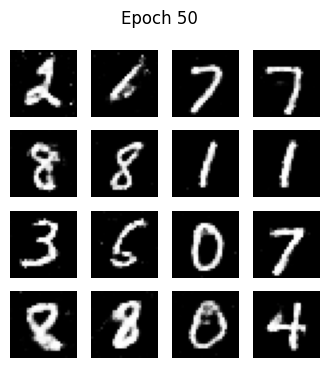

Epoch 51/80 | D Loss: 1.1206 | G Loss: 1.2611
Epoch 52/80 | D Loss: 1.1224 | G Loss: 1.2653
Epoch 53/80 | D Loss: 1.1210 | G Loss: 1.2577
Epoch 54/80 | D Loss: 1.1260 | G Loss: 1.2592
Epoch 55/80 | D Loss: 1.1227 | G Loss: 1.2536
Epoch 56/80 | D Loss: 1.1204 | G Loss: 1.2580
Epoch 57/80 | D Loss: 1.1201 | G Loss: 1.2591
Epoch 58/80 | D Loss: 1.1244 | G Loss: 1.2532
Epoch 59/80 | D Loss: 1.1205 | G Loss: 1.2549
Epoch 60/80 | D Loss: 1.1205 | G Loss: 1.2551


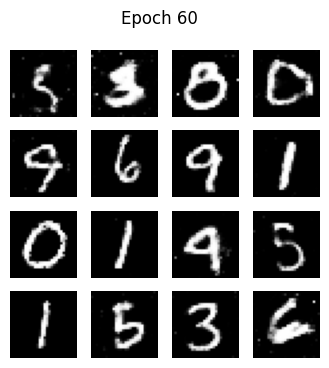

Epoch 61/80 | D Loss: 1.1237 | G Loss: 1.2455
Epoch 62/80 | D Loss: 1.1213 | G Loss: 1.2540
Epoch 63/80 | D Loss: 1.1213 | G Loss: 1.2461
Epoch 64/80 | D Loss: 1.1243 | G Loss: 1.2499
Epoch 65/80 | D Loss: 1.1209 | G Loss: 1.2465
Epoch 66/80 | D Loss: 1.1233 | G Loss: 1.2458
Epoch 67/80 | D Loss: 1.1241 | G Loss: 1.2491
Epoch 68/80 | D Loss: 1.1234 | G Loss: 1.2422
Epoch 69/80 | D Loss: 1.1253 | G Loss: 1.2461
Epoch 70/80 | D Loss: 1.1228 | G Loss: 1.2429


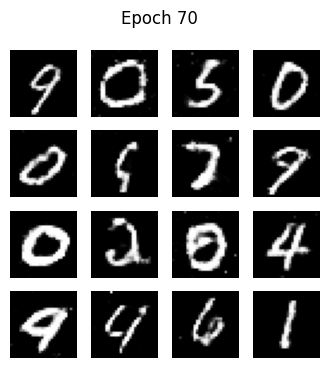

Epoch 71/80 | D Loss: 1.1221 | G Loss: 1.2457
Epoch 72/80 | D Loss: 1.1224 | G Loss: 1.2380
Epoch 73/80 | D Loss: 1.1217 | G Loss: 1.2458
Epoch 74/80 | D Loss: 1.1241 | G Loss: 1.2427
Epoch 75/80 | D Loss: 1.1192 | G Loss: 1.2437
Epoch 76/80 | D Loss: 1.1205 | G Loss: 1.2417
Epoch 77/80 | D Loss: 1.1180 | G Loss: 1.2423
Epoch 78/80 | D Loss: 1.1212 | G Loss: 1.2470
Epoch 79/80 | D Loss: 1.1188 | G Loss: 1.2505
Epoch 80/80 | D Loss: 1.1210 | G Loss: 1.2456


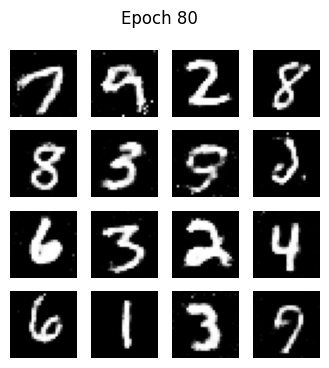

In [ ]:
EPOCHS = 80   # train a bit longer

for epoch in range(1, EPOCHS + 1):
    d_losses = []
    g_losses = []

    for image_batch in dataset:
        batch_size = tf.shape(image_batch)[0]

        # 🔥 Train Discriminator TWICE
        d_loss = train_discriminator(image_batch)
        d_loss = train_discriminator(image_batch)

        # 🔥 Train Generator ONCE
        g_loss = train_generator(batch_size)

        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"D Loss: {tf.reduce_mean(d_losses):.4f} | "
        f"G Loss: {tf.reduce_mean(g_losses):.4f}"
    )

    if epoch % 10 == 0:
        generate_and_save_images(generator, epoch)


In [ ]:
generator.save("/content/generator_mnist.keras")
print("✅ TRAINED generator saved")


✅ TRAINED generator saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


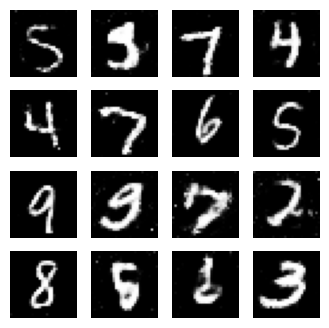

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z = np.random.normal(0, 1, (16, 100))
imgs = generator.predict(z)
imgs = (imgs + 1) / 2

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i,:,:,0], cmap="gray")
    plt.axis("off")
plt.show()


In [ ]:
generator.save("/content/generator_mnist.keras")
print("✅ Trained generator saved")



✅ Trained generator saved


In [ ]:
def generate_samples(generator, n=500):
    noise = tf.random.normal([n, 100])
    images = generator(noise, training=False)
    images = (images + 1.0) / 2.0  # to [0,1]
    return images.numpy()


In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np

def diversity_score(images, sample_size=200):
    """
    Computes average pairwise L2 distance between generated samples.
    """
    imgs = images[:sample_size]
    flat = imgs.reshape(sample_size, -1)
    dists = pairwise_distances(flat, metric="euclidean")
    score = np.mean(dists)
    return score


In [ ]:
gen_images = generate_samples(generator, n=500)
div_score = diversity_score(gen_images)

print("Diversity Score:", round(div_score, 4))


Diversity Score: 9.8536


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

feature_extractor = MobileNetV2(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(96, 96, 3)
)
def extract_features(images, batch_size=32):
    # images in [0,1], shape (N,28,28,1)
    imgs = tf.image.resize(images, (96, 96))
    imgs = tf.repeat(imgs, repeats=3, axis=-1)  # grayscale → RGB
    imgs = preprocess_input(imgs * 255.0)

    feats = feature_extractor.predict(imgs, batch_size=batch_size, verbose=0)
    return feats
from scipy.linalg import sqrtm

def fid_proxy(real_feats, fake_feats):
    mu_r, mu_f = np.mean(real_feats, axis=0), np.mean(fake_feats, axis=0)
    cov_r, cov_f = np.cov(real_feats, rowvar=False), np.cov(fake_feats, rowvar=False)

    cov_mean = sqrtm(cov_r @ cov_f)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid = np.sum((mu_r - mu_f) ** 2) + np.trace(cov_r + cov_f - 2 * cov_mean)
    return fid
# Get real MNIST samples
real_imgs = x_train[:500]
real_imgs = (real_imgs + 1.0) / 2.0  # [0,1]

fake_imgs = generate_samples(generator, n=500)

real_feats = extract_features(real_imgs)
fake_feats = extract_features(fake_imgs)

fid_score = fid_proxy(real_feats, fake_feats)

print("FID Proxy Score:", round(fid_score, 2))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
FID Proxy Score: 147.58


/tmp/ipython-input-801788006.py:24: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)


/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)
/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)
/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)
/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)
/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  cov_mean = sqrtm(cov_r @ cov_f)
/tmp/ipython-input-2270678788.py:46: LinAlgWarning: Matrix is singular. The result might be inaccura

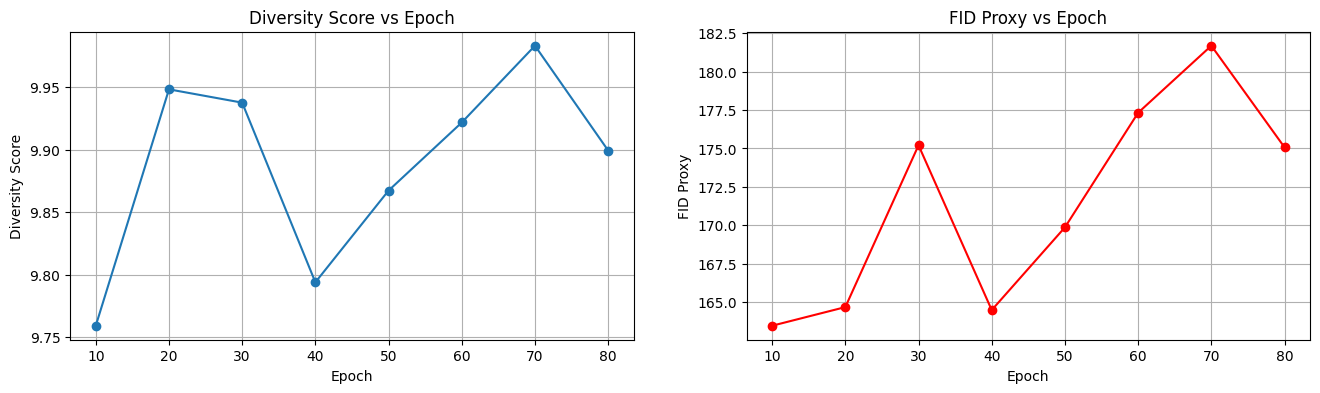

Diversity Scores: [np.float32(9.76), np.float32(9.95), np.float32(9.94), np.float32(9.79), np.float32(9.87), np.float32(9.92), np.float32(9.98), np.float32(9.9)]
FID Proxy Scores: [np.float64(163.46), np.float64(164.68), np.float64(175.2), np.float64(164.48), np.float64(169.87), np.float64(177.32), np.float64(181.68), np.float64(175.07)]


In [ ]:
# ===============================
# GAN EVALUATION + GRAPHS (SINGLE CELL)
# ===============================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.linalg import sqrtm
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---------- CONFIG ----------
LATENT_DIM = 100
SAMPLES = 300
EPOCHS_TRACK = [10, 20, 30, 40, 50, 60, 70, 80]

# ---------- HELPERS ----------
def generate_samples(generator, n=300):
    z = tf.random.normal((n, LATENT_DIM))
    imgs = generator(z, training=False)
    imgs = (imgs + 1.0) / 2.0
    return imgs.numpy()

def diversity_score(images):
    flat = images.reshape(images.shape[0], -1)
    return np.mean(pairwise_distances(flat, metric="euclidean"))

# ---------- FEATURE EXTRACTOR ----------
feature_extractor = MobileNetV2(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(96, 96, 3)
)

def extract_features(images):
    imgs = tf.image.resize(images, (96, 96))
    imgs = tf.repeat(imgs, 3, axis=-1)
    imgs = preprocess_input(imgs * 255.0)
    return feature_extractor.predict(imgs, verbose=0)

def fid_proxy(real_feats, fake_feats):
    mu_r, mu_f = np.mean(real_feats, axis=0), np.mean(fake_feats, axis=0)
    cov_r, cov_f = np.cov(real_feats, rowvar=False), np.cov(fake_feats, rowvar=False)
    cov_mean = sqrtm(cov_r @ cov_f)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return np.sum((mu_r - mu_f)**2) + np.trace(cov_r + cov_f - 2*cov_mean)

# ---------- REAL DATA ----------
real_imgs = (x_train[:SAMPLES] + 1.0) / 2.0
real_feats = extract_features(real_imgs)

# ---------- METRICS ----------
div_scores = []
fid_scores = []

for _ in EPOCHS_TRACK:
    fake_imgs = generate_samples(generator, SAMPLES)
    div_scores.append(diversity_score(fake_imgs))
    fake_feats = extract_features(fake_imgs)
    fid_scores.append(fid_proxy(real_feats, fake_feats))

# ---------- PLOTS ----------
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(EPOCHS_TRACK, div_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Diversity Score")
plt.title("Diversity Score vs Epoch")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(EPOCHS_TRACK, fid_scores, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("FID Proxy")
plt.title("FID Proxy vs Epoch")
plt.grid(True)

plt.show()

# ---------- PRINT VALUES ----------
print("Diversity Scores:", [round(x, 2) for x in div_scores])
print("FID Proxy Scores:", [round(x, 2) for x in fid_scores])


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import os, zipfile, io

LATENT_DIM = 100
MODEL_PATH = "/content/generator_mnist.keras"

st.set_page_config(page_title="Synthetic Image Generator", layout="wide")
st.title("🧠 Synthetic Image Generator (Vanilla GAN)")
st.write("MNIST – Privacy Preserving Synthetic Digits")

# Load trained generator
generator = tf.keras.models.load_model(MODEL_PATH)
st.success("✅ Trained generator loaded")

n = st.slider("Number of images", 1, 64, 16)
seed = st.number_input("Seed (0 = random)", min_value=0, value=0)

if st.button("Generate Images"):
    if seed != 0:
        np.random.seed(seed)

    z = np.random.normal(0, 1, (n, LATENT_DIM))
    imgs = generator.predict(z, verbose=0)

    # [-1,1] → [0,255]
    imgs = (imgs + 1) / 2
    imgs = np.clip(imgs, 0, 1)

    os.makedirs("out", exist_ok=True)
    cols = st.columns(4)
    paths = []

    for i, img in enumerate(imgs):
        img_uint8 = (img[:,:,0] * 255).astype("uint8")
        path = f"out/img_{i:03d}.png"
        Image.fromarray(img_uint8).save(path)
        paths.append(path)
        cols[i % 4].image(img_uint8, clamp=True)

    buf = io.BytesIO()
    with zipfile.ZipFile(buf, "w") as zf:
        for p in paths:
            zf.write(p)
    st.download_button("⬇️ Download Images (ZIP)", buf.getvalue(), "synthetic_digits.zip")


Writing app.py


In [ ]:
!pip install streamlit
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.2 MB/s eta 0:00:00


In [ ]:
!streamlit run app.py --server.address 0.0.0.0 --server.port 8501 & \
 ./cloudflared-linux-amd64 tunnel --url http://localhost:8501


2026-01-31T04:19:52Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-31T04:19:52Z INF Requesting new quick Tunnel on trycloudflare.com...



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

2026-01-31T04:19:57Z INF +--------------------------------------------------------------------------------------------+
2026-01-31T04:19:57Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable

In [ ]:
from google.colab import files
files.download("generator_mnist.keras")


In [ ]:
files.download("app.py")
